# Fake News detection

## Libraries installation

## Libraries et drive mounting

In [2]:
import pathlib

from typing import Dict

import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from transformers import RobertaTokenizer, RobertaModel, RobertaConfig

from torch.utils.data import Dataset, DataLoader, random_split
import torch
import torch.nn as nn
import torch.nn.functional as F

import pytorch_lightning as pl

from typing import Tuple, Any

Mounted at /content/drive


## Classes and functions

In [3]:
class FakeNewsPreprocessor:
    def __init__(self, root_path: pathlib.PurePath) -> None:
        self._true_mapping = {
            'politicsNews': 'politics',
            'worldnews': 'news'
        }
        self._fake_mapping = {
            'News': 'news',
            'politics': 'politics',
            'Government News': 'politics',
            'left-news': 'politics',
            'US_News': 'news',
            'Middle-east': 'news'
        }
        self._root_path = root_path
        self._df_fake, self._df_true = self._load_dataframes()
        self._dataframe = self._run_preprocessing()

    @property
    def fake(self):
        return self._df_fake
    
    @property
    def true(self):
        return self._df_true

    @property
    def dataframe(self):
        return self._dataframe

    def _load_dataframes(self) -> Tuple[pd.DataFrame, pd.DataFrame]:
        df_fake = pd.read_csv(self._root_path.joinpath('Fake.csv'))
        df_true = pd.read_csv(self._root_path.joinpath('True.csv'))
        return df_fake, df_true
    
    def _run_preprocessing(self) -> pd.DataFrame:
        self._df_true['subject'] = self._df_true['subject'].apply(lambda sub: self._true_mapping[sub])
        self._df_fake['subject'] = self._df_fake['subject'].apply(lambda sub: self._fake_mapping[sub])

        self._df_true['is_fake'] = 0
        self._df_fake['is_fake'] = 1

        df = pd.concat([self._df_true, self._df_fake]).reset_index(drop=True)
        df['content'] = df['title'] + '. ' + df['text']
        df.drop(columns=['date', 'title', 'text'], inplace=True)

        return df


class FakeNewsDataset(Dataset):
    def __init__(self, input_ids: torch.Tensor, attention_mask: torch.Tensor, targets: torch.Tensor, **torch_dataset) -> None:
        super(FakeNewsDataset, self).__init__(**torch_dataset)
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.targets = targets

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        return self.input_ids[idx], self.attention_mask[idx], self.targets[idx]

    def __len__(self) -> int:
        return len(self.input_ids)


class FakeNewsDetector(pl.LightningModule):
    def __init__(self, **lightning_module: Any) -> None:
        super(FakeNewsDetector, self).__init__(**lightning_module)
        self.roberta_encoder = RobertaModel.from_pretrained('roberta-base')
        self.regressor = nn.Linear(in_features=768, out_features=1)

        self._freeze_encoder_parameters()
    
    def _freeze_encoder_parameters(self) -> None:
        for name, params in self.roberta_encoder.named_parameters():
          if 'pooler' in name:
            continue
          
          params.requires_grad = False

    def configure_optimizers(self) -> torch.optim.Optimizer:
        return torch.optim.Adam(self.parameters(), lr=0.0001)
    
    def forward(self, x: Dict[str, torch.Tensor]) -> torch.Tensor:
        y = self.roberta_encoder(**x)['pooler_output']
        y = self.regressor(y)
        return y
    
    def training_step(self, train_batch, batch_idx) -> torch.Tensor:
        input_ids, input_attentions, targets = train_batch
        scores = self.forward({'input_ids': input_ids, 'attention_mask': input_attentions})
        probas = torch.sigmoid(scores).squeeze()
        loss = F.binary_cross_entropy(probas, targets)
        self.log('train_loss', loss)
        return loss
    
    def validation_step(self, valid_batch, batch_idx) -> torch.Tensor:
        input_ids, input_attentions, targets = valid_batch
        scores = self.forward({'input_ids': input_ids, 'attention_mask': input_attentions})
        probas = torch.sigmoid(scores).squeeze()
        loss = F.binary_cross_entropy(probas, targets)
        self.log('valid_loss', loss)
    
    def test_step(self, test_batch, batch_idx) -> torch.Tensor:
        input_ids, input_attentions, targets = test_batch
        scores = self.forward({'input_ids': input_ids, 'attention_mask': input_attentions})
        probas = torch.sigmoid(scores).squeeze()
        loss = F.binary_cross_entropy(probas, targets)
        self.log('test_loss', loss)
    
    def predict_step(self, predict_batch, batch_idx) -> torch.Tensor:
        input_ids, input_attentions, targets = predict_batch
        scores = self.forward({'input_ids': input_ids, 'attention_mask': input_attentions})
        probas = torch.sigmoid(scores).squeeze()
        return probas >= 0.5, targets

## Load data

In [4]:
preprocessor = FakeNewsPreprocessor(root_path=pathlib.PurePath('/content/drive/MyDrive/datasets/fake_news/'))
df = preprocessor.dataframe

## Répartition des sujets fake news

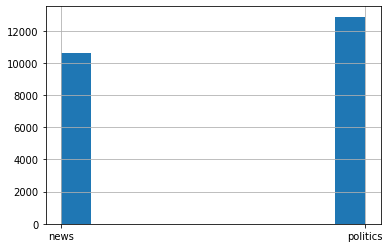

In [5]:
df[df['is_fake'] == 1]['subject'].hist();

Ensemble des news maintenant

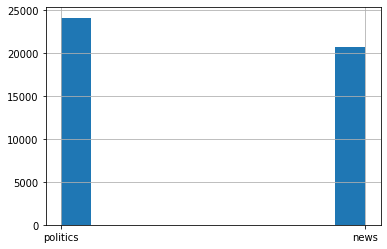

In [6]:
df['subject'].hist();

## Répartition de la longueur des articles

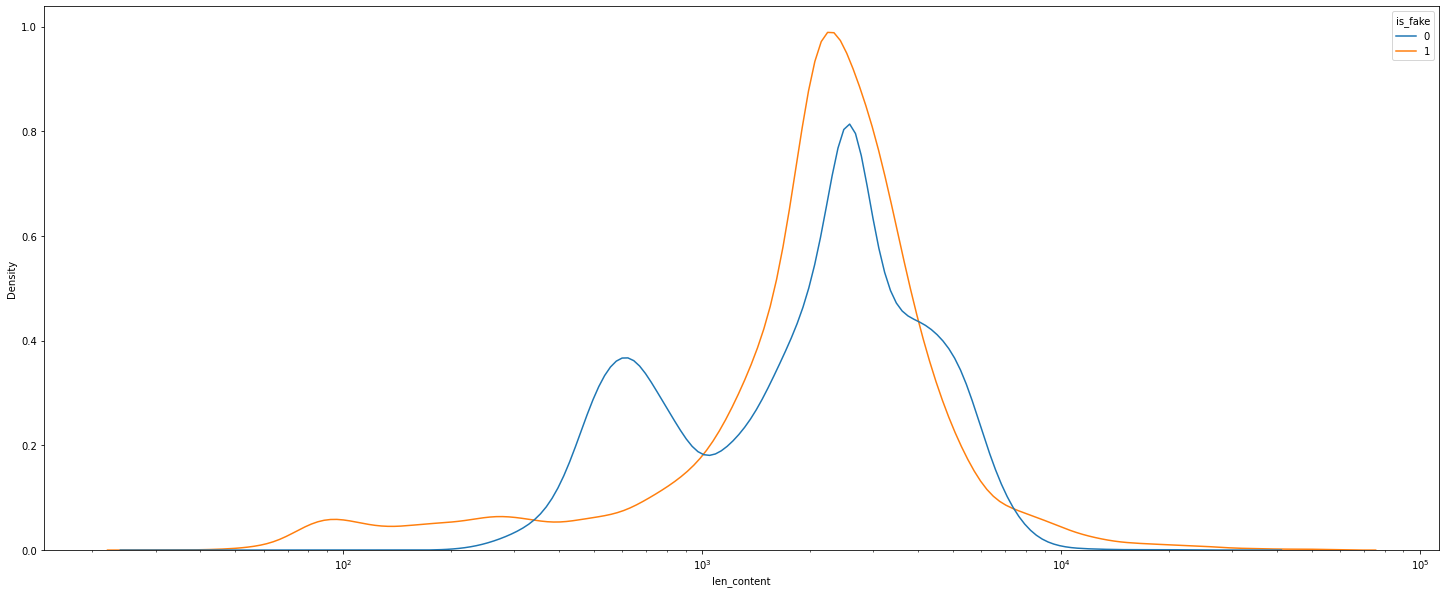

In [7]:
df['len_content'] = df['content'].apply(lambda content: len(content))

fig = plt.figure(figsize=(25, 10))
sns.kdeplot(data=df, x='len_content', log_scale=True, hue='is_fake');

La répartition en longueur de texte est également bien répartie ! On va pouvoir réfléchir à la stratégie de tokénization pour pouvoir classifier les articles, selon le contenu et le type d'article !

In [8]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

Plusieurs possibilités sont envisageables, la première serait de récupérer le code de l'encodeur BERT et d'utiliser uniquement la sortie de la dernière couche d'encodeur et moyenner la sortie de l'encodeur pour tous les chunks de texte. Sinon, on ne considère que la première partie du contenu (les 512 premiers tokens), puis that's it !

On peut commencer par la deuxième solution qui est plus simple à implémenter.

Pour construire notre Dataset et notre DataLoader, nous avons besoin de créer les tenseurs puis de les affecter directement au dataset, pré-tokéni

In [9]:
contents = df['content'].tolist()
targets = df['is_fake'].tolist()

tokenized_contents = tokenizer(contents, truncation=True, padding=True, return_tensors='pt')

In [10]:
tokenized_contents.keys()

dict_keys(['input_ids', 'attention_mask'])

In [11]:
dataset = FakeNewsDataset(tokenized_contents['input_ids'], tokenized_contents['attention_mask'], torch.FloatTensor(targets))
dataset_size = len(dataset)

train_ratio = 0.9
valid_ratio = 0.08
train_size = int(train_ratio * dataset_size)
valid_size = int(valid_ratio * dataset_size)
test_size = dataset_size - train_size - valid_size

train_set, valid_set, test_set = random_split(dataset, [train_size, valid_size, test_size])

train_loader = DataLoader(train_set, batch_size=128, num_workers=2)
valid_loader = DataLoader(valid_set, batch_size=128, num_workers=2)
test_loader = DataLoader(test_set, batch_size=64, num_workers=2)

In [12]:
model = FakeNewsDetector()
trainer = pl.Trainer(accelerator='gpu', max_epochs=3)

trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=valid_loader)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /content/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type         | Params
-----------

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.


In [13]:
trainer.predict(model, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 316it [00:00, ?it/s]

[(tensor([ True,  True, False, False,  True,  True,  True,  True, False, False,
          False,  True,  True, False,  True,  True, False,  True,  True, False,
          False, False, False, False, False,  True, False, False, False,  True,
          False,  True, False,  True,  True, False, False, False,  True, False,
          False,  True, False,  True, False,  True, False,  True, False,  True,
           True, False,  True, False,  True, False,  True, False, False, False,
           True,  True,  True, False]),
  tensor([1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 0., 1.,
          1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0.,
          0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0.,
          1., 0., 1., 0., 0., 0., 1., 1., 1., 0.])),
 (tensor([False, False,  True,  True,  True, False,  True, False,  True,  True,
           True, False,  True,  True, False, False, False,  True,  True,  True,
          False, Fals